In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.svm import SVC

In [24]:
X, y = make_classification(n_samples=1000,
                           n_features=15, 
                           n_informative=6, 
                           n_classes=2, 
                           shuffle=True, 
                           weights=(0.65, 0.35),
                           random_state=42)

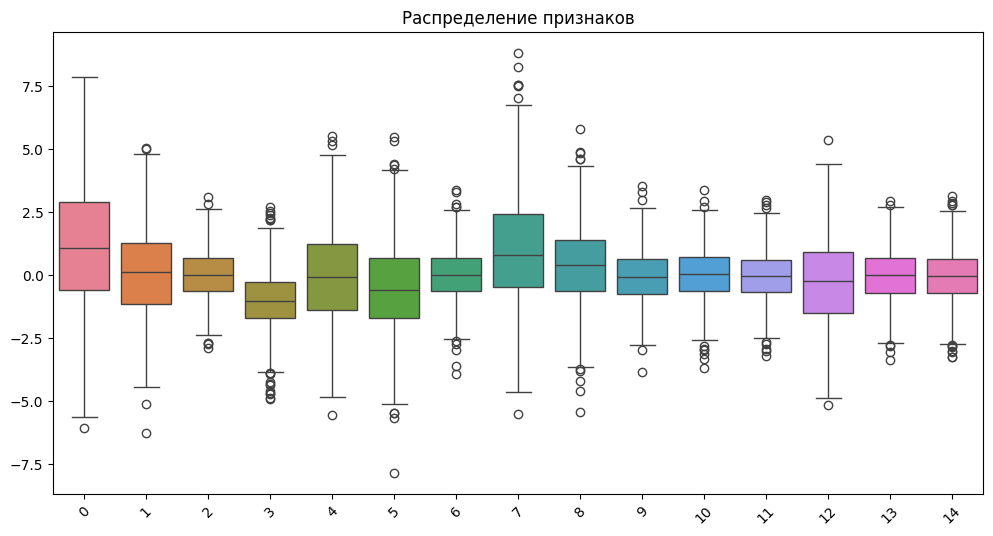

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Распределение признаков")
plt.show()

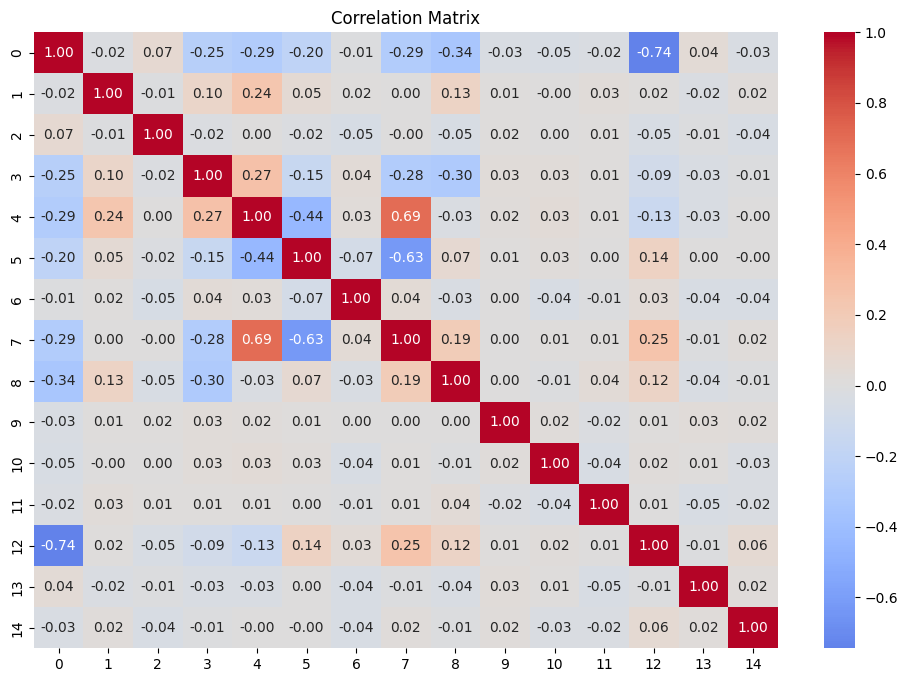

In [28]:
X_df = pd.DataFrame(X)
corr = X_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Видно, что некоторые фичи сильно скоррелированны с другими. Это особенно заметно на 7 признаке. Помимо этого, сильно коррелируют и первый с двенадцатым. Первый коррелирует с некоторыми другими признаками из первой половины. Использовать PCA, как мне кажется, в такой ситуации нерационально, поэтому построим линейную модель с L1-регуляризацией и попробуем занулить какие-нибудь коэффициенты, отбросив ненужные признаки.

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

lm = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lm.fit(x_train, y_train)
pred = lm.predict(x_test)
print(f'Accuracy on test: {accuracy_score(y_test, pred)}\nF1 on test: {f1_score(y_test, pred)}')

Accuracy on test: 0.764
F1 on test: 0.6380368098159509


In [59]:
print(lm.coef_)

[[-1.04611896 -0.11333609  0.00252309 -0.08889737  0.          0.51592325
  -0.00969107  0.          0.62520991 -0.08269732 -0.04635681  0.01783479
   1.03673049  0.13677802  0.10655856]]


Коэффициенты при 5 и 8 признаке занулились. Коэффициент же при 7 признаке близок к нулю. Учитывая, что он коррелирован с другими признаками, вероятно, это не статистически значимый коэффициент. Удалим эти 3 признака.

In [60]:
new_x_train, new_x_test = np.delete(x_train, [4, 6, 7], axis=1), np.delete(x_test, [4, 6, 7], axis=1)

In [68]:
class baseline:  # создадим baseline-модель, всегда предсказывающую самый частый класс в тренировочной выборке
    def __init__(self):
        self.ans = None
    def fit(self, X, y, num_classes=2):
        classes = [0 for _ in range(num_classes)]
        for el in y:
            classes[el] += 1
        classes = np.array(classes)
        self.ans = np.argmax(classes)
    def predict(self, x):
        return np.full(shape=(x.shape[0],), fill_value=self.ans)

baseline_model = baseline()
baseline_model.fit(x_train, y_train, num_classes=2)
baseline_pred = baseline_model.predict(x_test)
print(f'Accuracy on test: {accuracy_score(y_test, baseline_pred)}')

Accuracy on test: 0.644


To be continued...